<a href="https://colab.research.google.com/github/siaxvii/gnlp-final/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Run
!pip install transformers torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
#Run
import pandas as pd
import torch
import zipfile
from io import BytesIO
from PIL import Image
from IPython.display import display
from transformers import CLIPProcessor, CLIPModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm

# ---- Step 1: Manual File Uploads ----
print("⬆️ Please upload your training CSV, test CSV, and ZIP of images using the upload buttons below.")

import ipywidgets as widgets

upload_train_csv = widgets.FileUpload(accept='.csv', multiple=False, description='Upload Train CSV')
upload_test_csv = widgets.FileUpload(accept='.csv', multiple=False, description='Upload Test CSV')
upload_zip = widgets.FileUpload(accept='.zip', multiple=False, description='Upload Image ZIP')
display(upload_train_csv, upload_test_csv, upload_zip)


⬆️ Please upload your training CSV, test CSV, and ZIP of images using the upload buttons below.


FileUpload(value={}, accept='.csv', description='Upload Train CSV')

FileUpload(value={}, accept='.csv', description='Upload Test CSV')

FileUpload(value={}, accept='.zip', description='Upload Image ZIP')

In [50]:
#Run
# --- Read CSV ---
def get_dataframe(upload_widget):
    for file in upload_widget.value.values():
        content = file['content']
        return pd.read_csv(BytesIO(content))
    return None

# --- Extract images from zip ---
image_dict = {}

def extract_images(upload_widget):
    print("📦 Extracting images from ZIP (with nested folders)...")
    for file in upload_widget.value.values():
        zf = zipfile.ZipFile(BytesIO(file['content']))
        all_files = zf.namelist()
        print(f"Total files in ZIP: {len(all_files)}")
        for full_path in all_files:
            print("  →", full_path)  # 👈 print every file path


# --- Load CLIP ---
print("📥 Loading CLIP model...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("✅ CLIP model and processor loaded.")


📥 Loading CLIP model...
✅ CLIP model and processor loaded.


In [6]:
#Run, upload .zip
from google.colab import files

# Upload training CSV, test CSV, and ZIP of images
uploaded = files.upload()

Saving Images.zip to Images.zip


In [51]:
#Run
def custom_collate(batch):
    texts = [item[0]["input_ids"] for item in batch]
    masks = [item[0]["attention_mask"] for item in batch]
    images = [item[0]["pixel_values"] for item in batch]
    labels = torch.stack([item[1] for item in batch])

    # Pad input_ids and attention_mask
    input_ids = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    pixel_values = torch.stack(images)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "pixel_values": pixel_values
    }, labels


In [52]:
#Run
import zipfile
from PIL import Image

image_dict = {}
zip_path = "Images.zip"

with zipfile.ZipFile(zip_path, 'r') as zf:
    for full_path in zf.namelist():
        # Skip junk files from macOS
        if ('__MACOSX' in full_path or '/._' in full_path or full_path.startswith('._')):
            continue

        if full_path.lower().endswith(('.jpg', '.jpeg', '.png')) and not full_path.endswith('/'):
            filename = full_path.split('/')[-1].strip().lower()
            try:
                with zf.open(full_path) as img_file:
                    img = Image.open(img_file).convert("RGB")
                    image_dict[filename] = img
            except Exception as e:
                print(f"❌ Could not load {filename}: {e}")

print(f"✅ Loaded {len(image_dict)} images.")
print("📂 Sample image keys:", list(image_dict.keys())[:5])


✅ Loaded 4869 images.
📂 Sample image keys: ['1.jpg', '10.jpg', '1003.jpg', '1004.jpg', '1006.jpg']


In [63]:
#Run
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from zipfile import ZipFile
from io import BytesIO
from tqdm import tqdm

In [64]:
#Run
class CLIPSentimentClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.clip = clip_model
        for param in self.clip.parameters():
            param.requires_grad = False  # freeze CLIP
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )


    def forward(self, inputs):
        text_feat = self.clip.get_text_features(input_ids=inputs["input_ids"],
                                                attention_mask=inputs["attention_mask"])
        text_feat = text_feat / text_feat.norm(p=2, dim=-1, keepdim=True)

        image_feat = self.clip.get_image_features(pixel_values=inputs["pixel_values"])
        image_feat = image_feat / image_feat.norm(p=2, dim=-1, keepdim=True)

        combined = torch.cat([text_feat, image_feat], dim=1)
        return self.classifier(combined)


In [65]:
#Run
class CLIPDataset(Dataset):
    def __init__(self, dataframe, processor, label_encoder):
        self.df = dataframe
        self.processor = processor
        self.label_encoder = label_encoder
        self.labels = label_encoder.transform(self.df['label'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['Original English']
        fname = row['file name']
        image = image_dict.get(fname, Image.new("RGB", (224, 224), color='white'))

        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx])
        return inputs, label


In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#Run
train_df = get_dataframe(upload_train_csv)
test_df = get_dataframe(upload_test_csv)

# Label encoding
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

# Create DataLoader
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

dataset = CLIPDataset(train_df, processor, label_encoder)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

# Model
model = CLIPSentimentClassifier(clip_model, num_classes=len(label_encoder.classes_)).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4)

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"🔥 Epoch {epoch+1} Loss: {total_loss:.4f}")


Epoch 1/30: 100%|██████████| 199/199 [00:38<00:00,  5.17it/s]


🔥 Epoch 1 Loss: 218.0829


Epoch 2/30: 100%|██████████| 199/199 [00:37<00:00,  5.32it/s]


🔥 Epoch 2 Loss: 211.2550


Epoch 3/30: 100%|██████████| 199/199 [00:37<00:00,  5.28it/s]


🔥 Epoch 3 Loss: 191.6597


Epoch 4/30: 100%|██████████| 199/199 [00:37<00:00,  5.25it/s]


🔥 Epoch 4 Loss: 173.7766


Epoch 5/30: 100%|██████████| 199/199 [00:38<00:00,  5.23it/s]


🔥 Epoch 5 Loss: 160.8714


Epoch 6/30: 100%|██████████| 199/199 [00:38<00:00,  5.13it/s]


🔥 Epoch 6 Loss: 150.2482


Epoch 7/30: 100%|██████████| 199/199 [00:37<00:00,  5.24it/s]


🔥 Epoch 7 Loss: 140.0031


Epoch 8/30: 100%|██████████| 199/199 [00:37<00:00,  5.33it/s]


🔥 Epoch 8 Loss: 130.9366


Epoch 9/30: 100%|██████████| 199/199 [00:37<00:00,  5.26it/s]


🔥 Epoch 9 Loss: 121.6513


Epoch 10/30: 100%|██████████| 199/199 [00:38<00:00,  5.17it/s]


🔥 Epoch 10 Loss: 114.3405


Epoch 11/30: 100%|██████████| 199/199 [00:38<00:00,  5.16it/s]


🔥 Epoch 11 Loss: 106.6963


Epoch 12/30: 100%|██████████| 199/199 [00:37<00:00,  5.32it/s]


🔥 Epoch 12 Loss: 98.6658


Epoch 13/30: 100%|██████████| 199/199 [00:37<00:00,  5.32it/s]


🔥 Epoch 13 Loss: 91.5708


Epoch 14/30: 100%|██████████| 199/199 [00:38<00:00,  5.19it/s]


🔥 Epoch 14 Loss: 84.5293


Epoch 15/30: 100%|██████████| 199/199 [00:37<00:00,  5.27it/s]


🔥 Epoch 15 Loss: 77.2483


Epoch 16/30: 100%|██████████| 199/199 [00:37<00:00,  5.30it/s]


🔥 Epoch 16 Loss: 70.2397


Epoch 17/30: 100%|██████████| 199/199 [00:37<00:00,  5.26it/s]


🔥 Epoch 17 Loss: 63.2909


Epoch 18/30: 100%|██████████| 199/199 [00:37<00:00,  5.31it/s]


🔥 Epoch 18 Loss: 58.0020


Epoch 19/30: 100%|██████████| 199/199 [00:38<00:00,  5.21it/s]


🔥 Epoch 19 Loss: 51.2852


Epoch 20/30: 100%|██████████| 199/199 [00:38<00:00,  5.20it/s]


🔥 Epoch 20 Loss: 45.5418


Epoch 21/30: 100%|██████████| 199/199 [00:38<00:00,  5.20it/s]


🔥 Epoch 21 Loss: 40.1133


Epoch 22/30: 100%|██████████| 199/199 [00:38<00:00,  5.15it/s]


🔥 Epoch 22 Loss: 35.4518


Epoch 23/30: 100%|██████████| 199/199 [00:38<00:00,  5.19it/s]


🔥 Epoch 23 Loss: 31.0160


Epoch 24/30: 100%|██████████| 199/199 [00:38<00:00,  5.23it/s]


🔥 Epoch 24 Loss: 26.6723


Epoch 25/30: 100%|██████████| 199/199 [00:38<00:00,  5.23it/s]


🔥 Epoch 25 Loss: 22.3327


Epoch 26/30: 100%|██████████| 199/199 [00:38<00:00,  5.16it/s]


🔥 Epoch 26 Loss: 19.7941


Epoch 27/30: 100%|██████████| 199/199 [00:38<00:00,  5.14it/s]


🔥 Epoch 27 Loss: 16.5188


Epoch 28/30: 100%|██████████| 199/199 [00:39<00:00,  5.09it/s]


🔥 Epoch 28 Loss: 14.8400


Epoch 29/30: 100%|██████████| 199/199 [00:37<00:00,  5.24it/s]


🔥 Epoch 29 Loss: 12.1620


Epoch 30/30: 100%|██████████| 199/199 [00:37<00:00,  5.30it/s]

🔥 Epoch 30 Loss: 10.7410


In [71]:
#Run
class CLIPTestDataset(Dataset):
    def __init__(self, dataframe, processor, label_encoder):
        self.df = dataframe
        self.processor = processor
        self.label_encoder = label_encoder
        self.labels = label_encoder.transform(self.df['label'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['Original English']
        fname = row['file name']
        image = image_dict.get(fname, Image.new("RGB", (224, 224), color='white'))

        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx])
        return inputs, label


In [72]:
#Run
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Setup
test_df['file name'] = test_df['file name'].str.strip().str.lower()
test_df['label'] = test_df['label'].str.strip().str.lower()

test_dataset = CLIPTestDataset(test_df, processor, label_encoder)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=custom_collate)

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to original label names
y_true = label_encoder.inverse_transform(all_labels)
y_pred = label_encoder.inverse_transform(all_preds)

# Show metrics
print("✅ Evaluation Complete\n")
print(classification_report(y_true, y_pred, digits=3))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Macro:", f1_score(y_true, y_pred, average='macro'))
print("F1 Weighted:", f1_score(y_true, y_pred, average='weighted'))


Evaluating: 100%|██████████| 51/51 [00:09<00:00,  5.50it/s]

✅ Evaluation Complete

              precision    recall  f1-score   support

    negative      0.587     0.629     0.608       267
     neutral      0.450     0.468     0.459       267
    positive      0.603     0.536     0.567       267

    accuracy                          0.544       801
   macro avg      0.547     0.544     0.545       801
weighted avg      0.547     0.544     0.545       801

Accuracy: 0.5443196004993758
F1 Macro: 0.5445902834998179
F1 Weighted: 0.5445902834998179


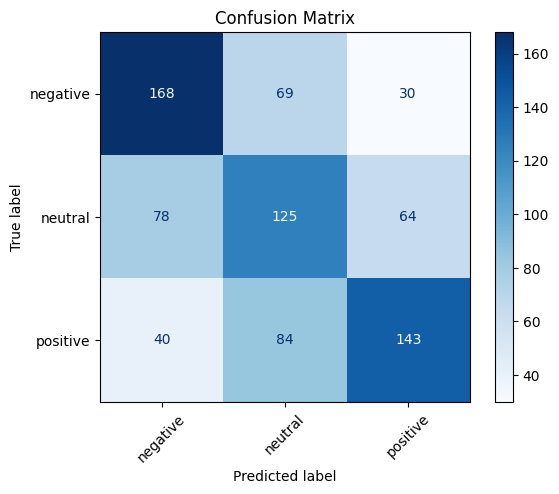

In [73]:
#Run
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
